### I) Loading data and preparing dataset - scope 2017-2018

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from datetime import datetime
import time
import matplotlib.pyplot as plt
%matplotlib inline
#%pylab inline
import itertools
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

In [2]:
path_project = Path.home() / Path('Google Drive/Felix')
path_data = path_project / Path("data")
path_dump = path_project / Path("dump")

In [3]:
# loading cdv data
file = path_data / Path("felix.csv")
with Path.open(file, 'rb') as fp:
    cdv = pd.read_csv(fp,  encoding='cp1252',low_memory=False, index_col = 0)
# loadind cdv data without format
file = path_data / Path("felix_ssfmt.csv")
with Path.open(file, 'rb') as fp:
    cdv_ssfmt = pd.read_csv(fp,  encoding='cp1252',low_memory=False, index_col = 0)

In [4]:
# load various variable set
filename = path_dump / Path("dict_var_groups.sav")
with open(filename, 'rb') as fp:
     dict_var_groups = pickle.load(fp)

scope_2017_2018_var = dict_var_groups['scope_2017_2018_var']
pred_var = dict_var_groups['pred_var']
com_var = dict_var_groups['com_var']
tech_var = dict_var_groups['tech_var']
text_var = dict_var_groups['text_var']
bizz_var = dict_var_groups['bizz_var']
cat_var = dict_var_groups['cat_var']
cat_max9_var = dict_var_groups['cat_max9_var']
cat_min10_var = dict_var_groups['cat_min10_var']
quant_var = dict_var_groups['quant_var']

In [5]:
exclusion = com_var | tech_var | bizz_var | text_var 
scope_2017_2018_var_kept = scope_2017_2018_var - exclusion
cat_var_kept = cat_max9_var & scope_2017_2018_var_kept
scope_quant_var = (quant_var & scope_2017_2018_var_kept) 
quant_null = np.sum(cdv_ssfmt.loc[:,scope_quant_var].isnull())
quant_var_kept = set(quant_null[quant_null < 200].index)

print(f"Out of {cdv.shape[1]} variable {len(scope_2017_2018_var)} \
are used in 2017 and 2018 ")
print(f"{len(scope_2017_2018_var & exclusion)} of 'technical' variable \
such as 'inseenum' are excluded ")
print(f"{len(scope_2017_2018_var_kept)} are remaining :")
print(f"\t{len(cat_var & scope_2017_2018_var_kept)} \
categorial variables : ")
print(f"\t\t{len(cat_max9_var & scope_2017_2018_var_kept)} \
with maximum 9 modalities  ")
print(f"\t\t{len(cat_min10_var & scope_2017_2018_var_kept)} \
with more modalities ... excluded")
print(f"\t{len(quant_var & scope_2017_2018_var_kept)} \
variables are quantitative ")
print(f"\t\t{len(quant_var_kept)} have less than 200 missing values")
print(f"\t\t{len(scope_quant_var)-len(quant_var_kept)} \
have more ... excluded")

scope = cat_var_kept | quant_var_kept
df = cdv_ssfmt.loc[cdv_ssfmt['ANNEEFUZ'].isin({39,40}),scope]
df.loc[:,cat_var_kept - {"HEUREUX"}] = cdv.loc[:,cat_var_kept - {"HEUREUX"}]
print(f"\nFinal number of variable kept : {df.shape[1]}")

Out of 353 variable 297 are used in 2017 and 2018 
31 of 'technical' variable such as 'inseenum' are excluded 
266 are remaining :
	180 categorial variables : 
		165 with maximum 9 modalities  
		15 with more modalities ... excluded
	86 variables are quantitative 
		60 have less than 200 missing values
		26 have more ... excluded

Final number of variable kept : 225


In [6]:
p = df.shape[1]
print(f"{p} columns out of which {len(cat_var_kept)-1} \
are corresponding to categorial features")

225 columns out of which 164 are corresponding to categorial features


In [7]:
df = pd.get_dummies(df, 
                    columns=cat_var_kept - {"HEUREUX"},
                    dummy_na = True,
                    drop_first=1)

In [8]:
q = df.shape[1]
print(f"{q} columns after encoding of {len(cat_var_kept)-1} categorial \
variables in {len(cat_var_kept)-1+q-p} binary variables \
(K-1 one hot encoding)")

645 columns after encoding of 164 categorial variables in 584 binary variables (K-1 one hot encoding)


In [9]:
# encoding of "HEUREUX" '[nsp]'
df.loc[df["HEUREUX"]==5,"HEUREUX"]= None
df = df.loc[np.isfinite(df['HEUREUX']).index,:]


# treating remaining missing values
features = df.columns.drop(['HEUREUX'])
df_tmp = df.loc[:,set(features) | {"HEUREUX"}].dropna()

X = df_tmp.loc[:,features]
y = df_tmp["HEUREUX"]

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42
                                                   )

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

print(f"Number exemple: {y.shape[0]}\n\
- training set: {y_train.shape[0]}\n\
- test set: {y_test.shape[0]}")
print(f"Number of features: p={X_train.shape[1]}")
print(f"Number of class: {len(np.unique(y))}")
for c in np.unique(y):
    print(f"class {c:0.0f} : {100*np.sum(y==c)/len(y):0.1f}%")

Number exemple: 5682
- training set: 4545
- test set: 1137
Number of features: p=644
Number of class: 4
class 1 : 2.0%
class 2 : 34.8%
class 3 : 47.9%
class 4 : 15.3%


### II) Feature selection

done in 761.0 s
Optimal number of features : 1


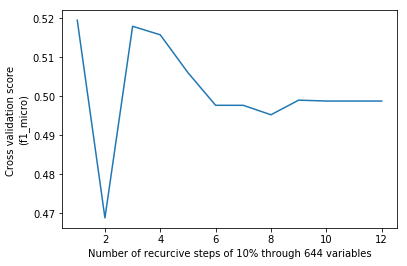

In [10]:
startTime = time.time()

scoring='f1_micro' 
step = 0.1

clf = LogisticRegression(C=1, 
                         penalty='l1', 
                         class_weight='balanced',
                         random_state=42)

rfecv = RFECV(estimator=clf, step=step, cv=StratifiedKFold(2),
              scoring=scoring)

rfecv.fit(X_train, y_train)
print(f"done in {time.time() - startTime:0.1f} s")
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel(f"Number of recurcive steps of {100*step:0.0f}% through {X_train.shape[1]} variables")
plt.ylabel(f"Cross validation score \n({scoring})")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [11]:
lasso_mask = rfecv.support_
X_train = X_train[:,lasso_mask]
X_test = X_test[:,lasso_mask]
print(f"Number of features: p={X_train.shape[1]}")

Number of features: p=1


### III) Model valuation

#### a) Random Forest

In [12]:
startTime = time.time()
n_estimators_range = [16,32,64,128,256]
max_depth_range = [2,4,8,16,32,64,128,256] 
param_grid = dict(n_estimators=n_estimators_range, max_depth = max_depth_range)


params = {'max_features' :'sqrt', 
          'random_state' : 32, 
          'min_samples_split' : 2, 
          'class_weight' : 'balanced'
         }

clf = RandomForestClassifier(**params)

grid = GridSearchCV(clf, 
                    scoring='f1_micro', 
                    param_grid=param_grid)

grid.fit(X_train, y_train)
print(f"Determination of optimal hyperparameters in \
{time.time() - startTime:0.1f} s")
print(f"Optimal values are {grid.best_params_} \n\
F1 weighted Score of cross valdation {100*grid.best_score_:0.2f}%")

# Learning on full training set with optimals hyperparameters and score on test set
params = {'max_features' :'sqrt', 'random_state' : 32, 
          'min_samples_split' : 2, 'class_weight' : 'balanced',
          'n_estimators' : grid.best_params_['n_estimators'],
          'max_depth' : grid.best_params_['max_depth']}
clf = RandomForestClassifier(**params).fit(X_train, y_train)

Determination of optimal hyperparameters in 83.5 s
Optimal values are {'max_depth': 2, 'n_estimators': 16} 
F1 weighted Score of cross valdation 30.56%


In [13]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


f1 score class 'Jamais' : 8.3%
f1 score class 'Occasionnellement' : 0.0%
f1 score class 'Assez souvent' : 49.1%
f1 score class 'Très souvent' : 25.9%
Average scores :
f1 macro : 20.8299 %
f1 weighted : 27.6477 %
acurracy : 30.5189 %
Confusion matrix, without normalization
[[ 11   0   8   9]
 [ 93   0 195  97]
 [ 94   0 266 176]
 [ 40   0  78  70]]
Normalized confusion matrix
[[ 0.39  0.    0.29  0.32]
 [ 0.24  0.    0.51  0.25]
 [ 0.18  0.    0.5   0.33]
 [ 0.21  0.    0.41  0.37]]


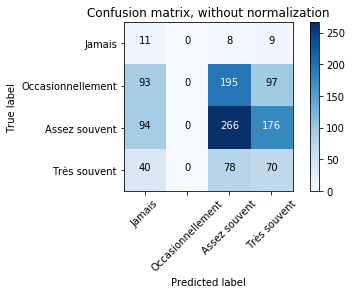

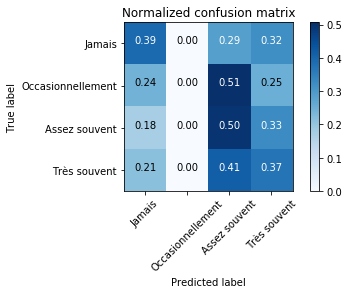

In [15]:
# Model evaluation
class_names = ["Jamais",
               "Occasionnellement",
               "Assez souvent",
               "Très souvent" ]
y_test_pred = clf.predict(X_test)
f1_scores = f1_score(y_test, y_test_pred, labels = [1,2,3,4], average=None)
for i,c in enumerate(class_names):
    print(f"f1 score class '{c}' : {100*f1_scores[i]:0.1f}%")
acurracy = clf.score(X_test, y_test)
f1_macro = f1_score(y_test, y_test_pred, average='macro')
f1_weighted = f1_score(y_test, y_test_pred, average='weighted')
print(f"Average scores :\nf1 macro : {f1_macro*100:0.4f} %\n\
f1 weighted : {f1_weighted*100:0.4f} %\nacurracy : {acurracy*100:0.4f} %")

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_test_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### b) Support Vector Machine with gausian kernel

In [16]:
startTime = time.time()

nb_value = 4
C_log = np.logspace(-2,2,nb_value)
gamma_log = np.logspace(-4,0, nb_value)
param_grid = dict(C=C_log, gamma=gamma_log)

params = { 'kernel' :'rbf', 'class_weight' : 'balanced'}

clf = SVC(**params)
grid = GridSearchCV(clf, scoring='f1_micro', param_grid=param_grid)
grid.fit(X_train, y_train)
print(f"Determination of optimal hyperparameters in {time.time() - startTime:0.1f} s")
print(f"Optimal values are {grid.best_params_} \nAccuracy of cross valdation {100*grid.best_score_:0.2f}%")

# Learning on full training set with optimals hyperparameters and score on test set
params = {'kernel' :'rbf',
          'C' : grid.best_params_['C'], 
          "gamma" : grid.best_params_['gamma'],
          'class_weight' : 'balanced'}
clf = SVC(**params).fit(X_train, y_train)
y_test_pred = clf.predict(X_test)

Determination of optimal hyperparameters in 59.7 s
Optimal values are {'C': 0.21544346900318834, 'gamma': 0.0001} 
Accuracy of cross valdation 43.76%


//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


f1 score class 'Jamais' : 0.0%
f1 score class 'Occasionnellement' : 0.0%
f1 score class 'Assez souvent' : 0.0%
f1 score class 'Très souvent' : 28.4%
Average scores :
f1 macro : 7.0943 %
f1 weighted : 4.6921 %
acurracy : 16.5347 %
Confusion matrix, without normalization
[[  0   0   0  28]
 [  0   0   0 385]
 [  0   0   0 536]
 [  0   0   0 188]]
Normalized confusion matrix
[[ 0.  0.  0.  1.]
 [ 0.  0.  0.  1.]
 [ 0.  0.  0.  1.]
 [ 0.  0.  0.  1.]]


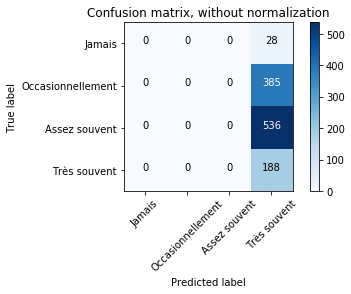

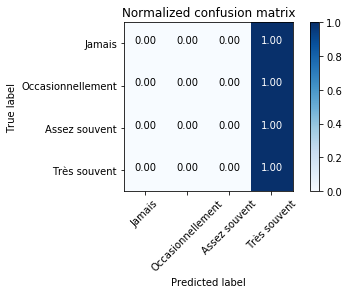

In [17]:
# Model evaluation
class_names = ["Jamais",
               "Occasionnellement",
               "Assez souvent",
               "Très souvent" ]
f1_scores = f1_score(y_test, y_test_pred, labels = [1,2,3,4], average=None)
for i,c in enumerate(class_names):
    print(f"f1 score class '{c}' : {100*f1_scores[i]:0.1f}%")
acurracy = clf.score(X_test, y_test)
f1_macro = f1_score(y_test, y_test_pred, average='macro')
f1_weighted = f1_score(y_test, y_test_pred, average='weighted')
print(f"Average scores :\nf1 macro : {f1_macro*100:0.4f} %\n\
f1 weighted : {f1_weighted*100:0.4f} %\nacurracy : {acurracy*100:0.4f} %")

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_test_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### IV) Load, learn and valuate model on clusters

In [18]:
# loading cdv data
file = path_data / Path("clustTest1.csv")
with Path.open(file, 'rb') as fp:
    clustTest1 = pd.read_csv(fp,  encoding='utf-8',low_memory=False, sep=";", index_col = 0)

In [19]:
clustTest1.head()

,clust1,clust2,clust3,clust4,clust5
INTER6,,,,,
390001,1,4,5,1.0,2.0
390002,2,6,4,7.0,5.0
390003,2,5,4,3.0,2.0
390004,3,6,5,7.0,5.0
390005,3,1,1,4.0,1.0


In [26]:
score = dict()

n_estimators_range = [16,32,64,128]
max_depth_range = [2,4,8,16,32,64] 
param_grid = dict(n_estimators=n_estimators_range, max_depth = max_depth_range)
params = {'max_features' :'sqrt', 
          'random_state' : 32, 
          'min_samples_split' : 2, 
          'class_weight' : 'balanced'
         }

score_clustering_methods = []
clustering_methods = clustTest1.columns

for method in clustering_methods:
    print(f"\nAnalysis cluster method {method}")
    cluster_list = clustTest1[method].unique()
    print(f"liste of clusters : {cluster_list}")
    score_cluster = []
    for cluster in cluster_list:
        index_scope = clustTest1.loc[clustTest1[method]==cluster,:].index
        print(f"cluster {cluster} : {len(index_scope)} elements")
        
        # treating remaining missing values
        features = df.columns.drop(['HEUREUX'])[lasso_mask]
        df_tmp = df.loc[index_scope,set(features) | {"HEUREUX"}].dropna()

        X = df_tmp.loc[:,features]
        y = df_tmp["HEUREUX"]

        X_train, X_test, y_train, y_test = train_test_split(X, 
                                                            y, 
                                                            test_size=0.2, 
                                                            random_state=42
                                                           )

        scaler = StandardScaler().fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)

        print(f"Number exemple: {y.shape[0]}\n\
        - training set: {y_train.shape[0]}\n\
        - test set: {y_test.shape[0]}")
        print(f"Number of features: p={X_train.shape[1]}")
        print(f"Number of class: {len(np.unique(y))}")
        for c in np.unique(y):
            print(f"class {c:0.0f} : {100*np.sum(y==c)/len(y):0.1f}%")
            
            
        startTime = time.time()
        clf = RandomForestClassifier(**params)
        grid = GridSearchCV(clf, 
                            scoring='f1_micro', 
                            param_grid=param_grid)

        grid.fit(X_train, y_train)
        print(f"Determination of optimal hyperparameters in \
        {time.time() - startTime:0.1f} s")
        print(f"Optimal values are {grid.best_params_} \n\
        F1 weighted Score of cross valdation {100*grid.best_score_:0.2f}%")

        # Learning on full training set with optimals hyperparameters and score on test set
        params_opt = {'max_features' :'sqrt', 'random_state' : 32, 
                      'min_samples_split' : 2, 'class_weight' : 'balanced',
                      'n_estimators' : grid.best_params_['n_estimators'],
                      'max_depth' : grid.best_params_['max_depth']}
        clf = RandomForestClassifier(**params_opt).fit(X_train, y_train)

            
        y_test_pred = clf.predict(X_test)
        f1_scores = f1_score(y_test, y_test_pred, labels = [1,2,3,4], average=None)
        accuracy = clf.score(X_test, y_test)
        f1_macro = f1_score(y_test, y_test_pred, average='macro')
        f1_weighted = f1_score(y_test, y_test_pred, average='weighted')
            
        res  = {'f1_scores' : f1_scores,
                'accuracy' : accuracy,
                'f1_macro' : f1_macro,
                'f1_weighted' : f1_weighted}
            
        cl = {'cluster' : cluster,
              'model' : 'RandomForestClassifier',
              'params' : params_opt,
              'metrics' : res
             }
         
        score_cluster.append(cl)
        
    d = {'clustering_method' : method,
         'cluster_scores' : score_cluster
        }
    score_clustering_methods.append(d) 

print(score_clustering_methods)


Analysis cluster method clust1
liste of clusters : [1 2 3 4 5 6]
cluster 1 : 295 elements
Number exemple: 292
        - training set: 233
        - test set: 59
Number of features: p=1
Number of class: 4
class 1 : 5.1%
class 2 : 41.1%
class 3 : 39.0%
class 4 : 14.7%
Determination of optimal hyperparameters in         10.4 s
Optimal values are {'max_depth': 2, 'n_estimators': 32} 
        F1 weighted Score of cross valdation 24.89%
cluster 2 : 1729 elements
Number exemple: 1725
        - training set: 1380
        - test set: 345
Number of features: p=1
Number of class: 4
class 1 : 2.3%
class 2 : 37.9%
class 3 : 46.8%
class 4 : 13.0%


//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Determination of optimal hyperparameters in         11.2 s
Optimal values are {'max_depth': 2, 'n_estimators': 32} 
        F1 weighted Score of cross valdation 26.45%
cluster 3 : 3633 elements
Number exemple: 3586
        - training set: 2868
        - test set: 718
Number of features: p=1
Number of class: 4
class 1 : 1.6%
class 2 : 33.0%
class 3 : 49.2%
class 4 : 16.1%


//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Determination of optimal hyperparameters in         12.7 s
Optimal values are {'max_depth': 4, 'n_estimators': 16} 
        F1 weighted Score of cross valdation 31.94%
cluster 4 : 218 elements
Number exemple: 217
        - training set: 173
        - test set: 44
Number of features: p=1
Number of class: 4
class 1 : 0.9%
class 2 : 27.2%
class 3 : 49.8%
class 4 : 22.1%


//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


Determination of optimal hyperparameters in         10.1 s
Optimal values are {'max_depth': 2, 'n_estimators': 16} 
        F1 weighted Score of cross valdation 38.15%
cluster 5 : 137 elements
Number exemple: 137
        - training set: 109
        - test set: 28
Number of features: p=1
Number of class: 4
class 1 : 2.9%
class 2 : 38.7%
class 3 : 43.8%
class 4 : 14.6%


//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


Determination of optimal hyperparameters in         9.7 s
Optimal values are {'max_depth': 2, 'n_estimators': 16} 
        F1 weighted Score of cross valdation 22.94%
cluster 6 : 24 elements
Number exemple: 24
        - training set: 19
        - test set: 5
Number of features: p=1
Number of class: 4
class 1 : 4.2%
class 2 : 45.8%
class 3 : 29.2%
class 4 : 20.8%


//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Determination of optimal hyperparameters in         10.1 s
Optimal values are {'max_depth': 2, 'n_estimators': 16} 
        F1 weighted Score of cross valdation 21.05%

Analysis cluster method clust2
liste of clusters : [4 6 5 1 3 2 7]
cluster 4 : 212 elements
Number exemple: 211
        - training set: 168
        - test set: 43
Number of features: p=1
Number of class: 4
class 1 : 8.1%
class 2 : 42.7%
class 3 : 32.2%
class 4 : 17.1%


//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Determination of optimal hyperparameters in         10.5 s
Optimal values are {'max_depth': 2, 'n_estimators': 32} 
        F1 weighted Score of cross valdation 38.10%
cluster 6 : 1137 elements
Number exemple: 1132
        - training set: 905
        - test set: 227
Number of features: p=1
Number of class: 4
class 1 : 1.8%
class 2 : 33.3%
class 3 : 48.2%
class 4 : 16.7%


//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Determination of optimal hyperparameters in         11.5 s
Optimal values are {'max_depth': 4, 'n_estimators': 16} 
        F1 weighted Score of cross valdation 24.64%
cluster 5 : 750 elements
Number exemple: 749
        - training set: 599
        - test set: 150
Number of features: p=1
Number of class: 4
class 1 : 1.5%
class 2 : 32.7%
class 3 : 48.7%
class 4 : 17.1%
Determination of optimal hyperparameters in         10.4 s
Optimal values are {'max_depth': 2, 'n_estimators': 16} 
        F1 weighted Score of cross valdation 27.55%
cluster 1 : 1257 elements
Number exemple: 1218
        - training set: 974
        - test set: 244
Number of features: p=1
Number of class: 4
class 1 : 2.1%
class 2 : 37.6%
class 3 : 47.0%
class 4 : 13.4%


//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Determination of optimal hyperparameters in         11.2 s
Optimal values are {'max_depth': 2, 'n_estimators': 16} 
        F1 weighted Score of cross valdation 25.56%
cluster 3 : 1254 elements
Number exemple: 1248
        - training set: 998
        - test set: 250
Number of features: p=1
Number of class: 4
class 1 : 1.2%
class 2 : 31.7%
class 3 : 52.6%
class 4 : 14.6%


//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Determination of optimal hyperparameters in         11.5 s
Optimal values are {'max_depth': 2, 'n_estimators': 16} 
        F1 weighted Score of cross valdation 24.45%
cluster 2 : 857 elements
Number exemple: 855
        - training set: 684
        - test set: 171
Number of features: p=1
Number of class: 4
class 1 : 1.6%
class 2 : 31.7%
class 3 : 49.5%
class 4 : 17.2%


//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Determination of optimal hyperparameters in         10.9 s
Optimal values are {'max_depth': 2, 'n_estimators': 16} 
        F1 weighted Score of cross valdation 35.96%
cluster 7 : 569 elements
Number exemple: 568
        - training set: 454
        - test set: 114
Number of features: p=1
Number of class: 4
class 1 : 2.8%
class 2 : 43.0%
class 3 : 41.0%
class 4 : 13.2%


//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Determination of optimal hyperparameters in         10.9 s
Optimal values are {'max_depth': 2, 'n_estimators': 32} 
        F1 weighted Score of cross valdation 26.87%

Analysis cluster method clust3
liste of clusters : [5 4 1 2 3]
cluster 5 : 373 elements
Number exemple: 373
        - training set: 298
        - test set: 75
Number of features: p=1
Number of class: 4
class 1 : 4.3%
class 2 : 41.6%
class 3 : 37.5%
class 4 : 16.6%


//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Determination of optimal hyperparameters in         10.6 s
Optimal values are {'max_depth': 2, 'n_estimators': 16} 
        F1 weighted Score of cross valdation 22.82%
cluster 4 : 2682 elements
Number exemple: 2674
        - training set: 2139
        - test set: 535
Number of features: p=1
Number of class: 4
class 1 : 1.4%
class 2 : 34.3%
class 3 : 49.0%
class 4 : 15.3%


//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Determination of optimal hyperparameters in         17.5 s
Optimal values are {'max_depth': 2, 'n_estimators': 16} 
        F1 weighted Score of cross valdation 32.68%
cluster 1 : 1593 elements
Number exemple: 1553
        - training set: 1242
        - test set: 311
Number of features: p=1
Number of class: 4
class 1 : 2.2%
class 2 : 34.9%
class 3 : 48.4%
class 4 : 14.5%


//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Determination of optimal hyperparameters in         20.0 s
Optimal values are {'max_depth': 2, 'n_estimators': 16} 
        F1 weighted Score of cross valdation 37.04%
cluster 2 : 1246 elements
Number exemple: 1240
        - training set: 992
        - test set: 248
Number of features: p=1
Number of class: 4
class 1 : 1.8%
class 2 : 33.0%
class 3 : 48.6%
class 4 : 16.6%


//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Determination of optimal hyperparameters in         19.4 s
Optimal values are {'max_depth': 2, 'n_estimators': 16} 
        F1 weighted Score of cross valdation 25.10%
cluster 3 : 142 elements
Number exemple: 141
        - training set: 112
        - test set: 29
Number of features: p=1
Number of class: 4
class 1 : 5.7%
class 2 : 40.4%
class 3 : 41.1%
class 4 : 12.8%


//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Determination of optimal hyperparameters in         15.2 s
Optimal values are {'max_depth': 2, 'n_estimators': 16} 
        F1 weighted Score of cross valdation 22.32%

Analysis cluster method clust4
liste of clusters : [  1.   7.   3.   4.   5.   2.  nan   6.]
cluster 1.0 : 556 elements
Number exemple: 556
        - training set: 444
        - test set: 112
Number of features: p=1
Number of class: 4
class 1 : 3.2%
class 2 : 21.8%
class 3 : 44.8%
class 4 : 30.2%


//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Determination of optimal hyperparameters in         18.2 s
Optimal values are {'max_depth': 2, 'n_estimators': 16} 
        F1 weighted Score of cross valdation 15.77%
cluster 7.0 : 786 elements
Number exemple: 786
        - training set: 628
        - test set: 158
Number of features: p=1
Number of class: 4
class 1 : 2.8%
class 2 : 45.9%
class 3 : 43.3%
class 4 : 8.0%


//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Determination of optimal hyperparameters in         17.4 s
Optimal values are {'max_depth': 2, 'n_estimators': 16} 
        F1 weighted Score of cross valdation 9.24%
cluster 3.0 : 775 elements
Number exemple: 774
        - training set: 619
        - test set: 155
Number of features: p=1
Number of class: 4
class 1 : 0.6%
class 2 : 27.1%
class 3 : 52.1%
class 4 : 20.2%


//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Determination of optimal hyperparameters in         16.8 s
Optimal values are {'max_depth': 2, 'n_estimators': 32} 
        F1 weighted Score of cross valdation 17.77%
cluster 4.0 : 1055 elements
Number exemple: 1051
        - training set: 840
        - test set: 211
Number of features: p=1
Number of class: 4
class 1 : 1.0%
class 2 : 34.7%
class 3 : 53.6%
class 4 : 10.8%


//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Determination of optimal hyperparameters in         16.9 s
Optimal values are {'max_depth': 2, 'n_estimators': 16} 
        F1 weighted Score of cross valdation 28.81%
cluster 5.0 : 909 elements
Number exemple: 903
        - training set: 722
        - test set: 181
Number of features: p=1
Number of class: 4
class 1 : 1.0%
class 2 : 26.9%
class 3 : 51.9%
class 4 : 20.2%


//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Determination of optimal hyperparameters in         16.9 s
Optimal values are {'max_depth': 4, 'n_estimators': 64} 
        F1 weighted Score of cross valdation 21.75%


//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


cluster 2.0 : 795 elements
Number exemple: 793
        - training set: 634
        - test set: 159
Number of features: p=1
Number of class: 4
class 1 : 1.1%
class 2 : 40.4%
class 3 : 46.9%
class 4 : 11.6%
Determination of optimal hyperparameters in         16.7 s
Optimal values are {'max_depth': 2, 'n_estimators': 32} 
        F1 weighted Score of cross valdation 39.27%
cluster nan : 0 elements


//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by StandardScaler.

In [ ]:
score_clustering_methods

In [ ]:
score_clustering_methods[0]['clustering_method']

In [ ]:
score_clustering_methods[0]['cluster_scores']